In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
p = '/home/qnicolas/iac_notebooks/tools/'
if p not in sys.path:
    sys.path.append(p)
from generalTools import ddx, ddy, sel_months, quickplot, lon_360_to_180

import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 2

This notebook averages January NCEP-NCAR reanalysis data and calculates various forcing terms

In [2]:
def calc_HEHFD(ds):
    return ds.U * ddx(ds.T) + ds.V * ddy(ds.T) 
def calc_VEHFD(ds):
    return ds.W * (ds.T + ds.Z * 9.81/1004.).differentiate('level')/100.

In [3]:
def calc_MFD_U(ds):
    return ds.U * ddx(ds.U) + ds.V * ddy(ds.U) + ds.W * ds.U.differentiate('level')/100. - ds.U * ds.V * np.minimum(5.,np.maximum(-5.,np.tan(ds.lat * np.pi/180))) / 6.37122e6
def calc_MFD_V(ds):
    return ds.U * ddx(ds.V) + ds.V * ddy(ds.V) + ds.W * ds.V.differentiate('level')/100. + ds.U**2 * np.minimum(5.,np.maximum(-5.,np.tan(ds.lat * np.pi/180))) / 6.37122e6


In [2]:
path = "/net/atmos/data/ncep/reanalysis"
target_dir = "/net/helium/atmosdyn/qnicolas/ncep_means"


# Average NCEP-NCAR January data from 6-h values and calculate total heat flux divergence

In [ ]:
for year in range(1949,2000):
    print(year)
    T = sel_months(xr.open_dataset(f"{path}/pressure/air.{year}.nc"), [1,]).rename(air = 'T')
    U = sel_months(xr.open_dataset(f"{path}/pressure/uwnd.{year}.nc"), [1,]).rename(uwnd = 'U')
    V = sel_months(xr.open_dataset(f"{path}/pressure/vwnd.{year}.nc"), [1,]).rename(vwnd = 'V')
    W = sel_months(xr.open_dataset(f"{path}/pressure/omega.{year}.nc"), [1,]).rename(omega = 'W')
    Z = sel_months(xr.open_dataset(f"{path}/pressure/hgt.{year}.nc"), [1,]).rename(hgt = 'Z')
    SP = sel_months(xr.open_dataset(f"{path}/surface/pres.sfc.{year}.nc"), [1,]).rename(pres = 'SP')

    ds_jan = xr.merge([T, U, V, W, Z, SP])

    ds_jan.mean('time').to_netcdf(target_dir + f"/ncep_jan_{year}.nc")

    HFD = (calc_HEHFD(ds_jan) + calc_VEHFD(ds_jan)).mean('time').to_dataset(name='HFD')
    HFD.HFD.attrs['units'] = 'K/s'
    HFD.HFD.attrs['long_name'] = 'Total Heat Flux Divergence'
    HFD.to_netcdf(target_dir + f"/ncep_jan_HFD_{year}.nc")

1949
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


# Aggregate monthly averages and calculate diagnostics 

In [ ]:
# instantiate dask client with 8 workers
from dask.distributed import Client
client = Client(n_workers=4,threads_per_worker=1,memory_limit='20G',dashboard_address=':40000')
client

ncep_jan_all = xr.open_mfdataset(target_dir + "/ncep_jan_*.nc", combine='nested', concat_dim='time',parallel=True,compat='override',coords='minimal')
ncep_jan_all_mean = ncep_jan_all.mean('time').compute()
ncep_jan_all_mean.to_netcdf(target_dir + "/ncep_jan_all_mean.nc")

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/qnicolas/proxy/40000/status,
Dashboard: /user/qnicolas/proxy/40000/status,Workers: 4
Total threads: 4,Total memory: 74.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44915,Workers: 4
Dashboard: /user/qnicolas/proxy/40000/status,Total threads: 4
Started: Just now,Total memory: 74.51 GiB
Comm: tcp://127.0.0.1:36893,Total threads: 1
Dashboard: /user/qnicolas/proxy/33187/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:33147,


In [3]:
ncep_jan_all_mean = xr.open_dataset(target_dir + "/ncep_jan_all_mean.nc")

In [16]:
Zsfc = xr.open_dataset(path + '/surface/hgt.sfc.nc').rename(hgt='ZSFC').ZSFC.isel(time=0)

In [17]:
QDIAB = ncep_jan_all_mean.HFD
MHFD = calc_HEHFD(ncep_jan_all_mean) + calc_VEHFD(ncep_jan_all_mean)
EHFD = QDIAB - MHFD


In [18]:
mfd_u = calc_MFD_U(ncep_jan_all_mean)
mfd_v = calc_MFD_V(ncep_jan_all_mean)

f = 2 * 2 * np.pi / 86400 * np.sin(ncep_jan_all_mean.lat * np.pi / 180)

emfd_u = - mfd_u + f * ncep_jan_all_mean.V - ddx(ncep_jan_all_mean.Z)*9.81
emfd_v = - mfd_v - f * ncep_jan_all_mean.U - ddy(ncep_jan_all_mean.Z)*9.81
emfd_u[:,0] = 0.; emfd_u[:,-1] = 0.
emfd_v[:,0] = 0.; emfd_v[:,-1] = 0.

In [19]:
forcings = xr.merge([Zsfc, QDIAB.to_dataset(name = 'QDIAB'),  EHFD.to_dataset(name = 'EHFD'), emfd_u.to_dataset(name='EMFD_U'), emfd_v.to_dataset(name='EMFD_V'), ncep_jan_all_mean[['SP',]]])

In [20]:
basic_state = ncep_jan_all_mean[['U', 'V', 'W', 'T', 'SP']].mean('lon')
basic_state

<xarray.Dataset> Size: 21kB
Dimensions:  (level: 17, lat: 73)
Coordinates:
  * level    (level) float32 68B 10.0 20.0 30.0 50.0 ... 700.0 850.0 925.0 1e+03
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    U        (level, lat) float32 5kB 6.782e-06 5.315 ... -0.5603 9.007e-06
    V        (level, lat) float32 5kB 7.629e-06 -0.04302 ... 0.4612 8.848e-06
    W        (level, lat) float32 5kB nan nan nan ... 0.03349 0.02367 0.01728
    T        (level, lat) float32 5kB 208.4 208.5 209.0 ... 271.8 270.9 270.4
    SP       (lat) float32 292B 1.016e+05 1.015e+05 ... 7.033e+04 6.844e+04

In [28]:
# run_dir = '/home/qnicolas/stationaryWave'
# basic_state.fillna(0.).rename(level='pressure').to_netcdf(run_dir + "/ncep_jan_basic_state.nc")
lon_360_to_180(forcings.fillna(0.).rename(level='pressure')   ).to_netcdf(run_dir + "/ncep_jan_forcings.nc")

# Visualize forcings

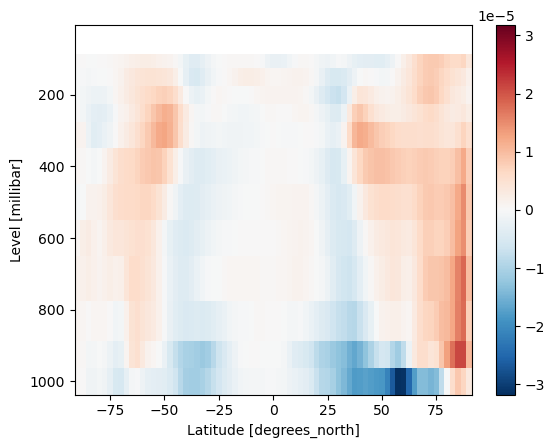

In [22]:
(-EHFD).mean('lon').plot(y='level',yincrease=False)

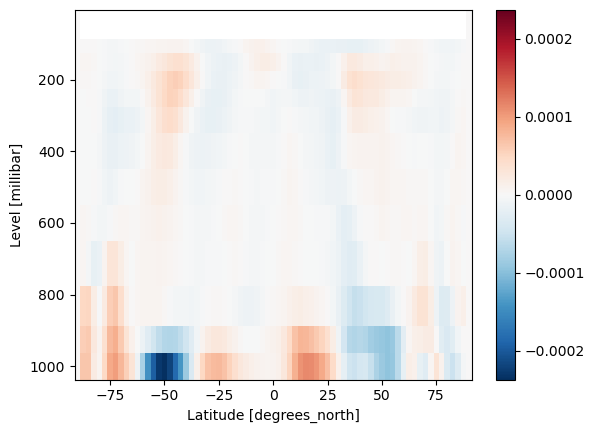

In [23]:
(-emfd_u).mean('lon').plot(y='level',yincrease=False)

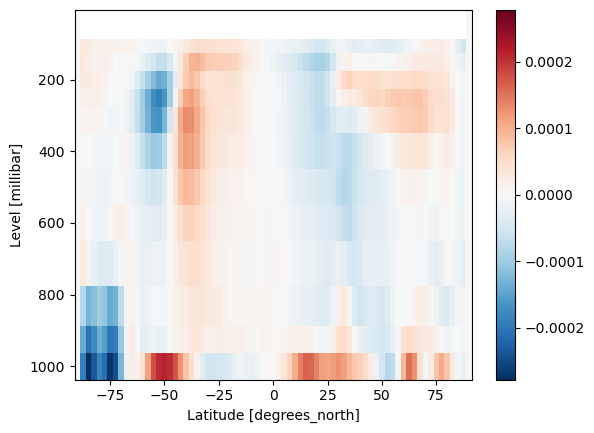

In [14]:
(-emfd_v).mean('lon').plot(y='level',yincrease=False)

<GeoAxes: title={'center': 'level = 250.0 [millibar]'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

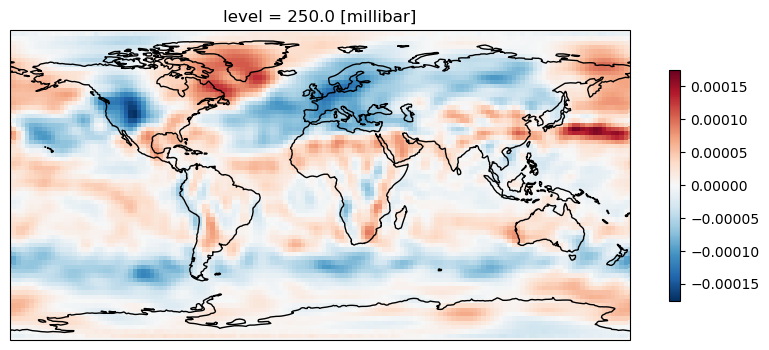

In [24]:
quickplot(emfd_u.isel(level=8), cmap = 'RdBu_r')

<GeoAxes: title={'center': 'level = 250.0 [millibar]'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

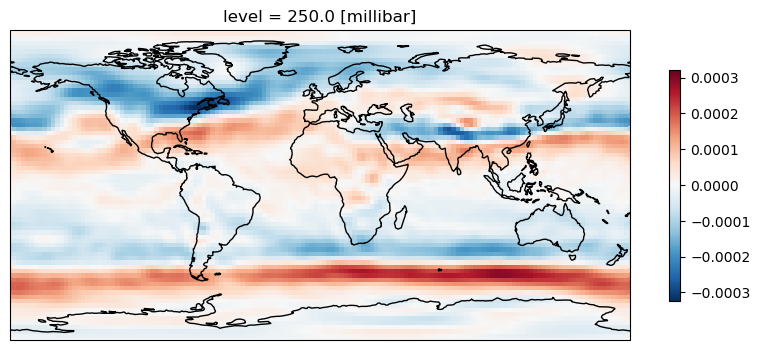

In [25]:
quickplot(emfd_v.isel(level=8), cmap = 'RdBu_r')

<GeoAxes: title={'center': 'level = 250.0 [millibar]'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

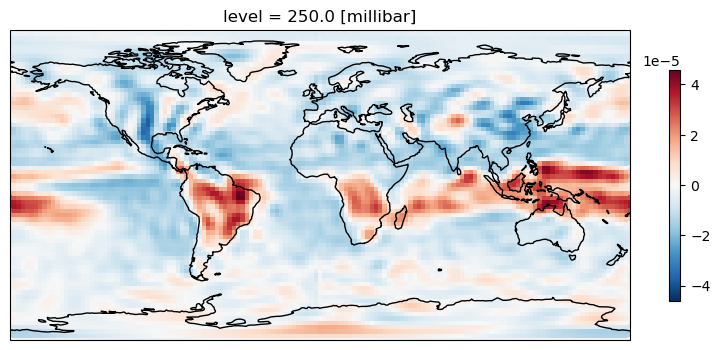

In [26]:
quickplot(ncep_jan_all_mean.HFD.isel(level=8), cmap = 'RdBu_r')

<GeoAxes: title={'center': 'level = 600.0 [millibar]'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

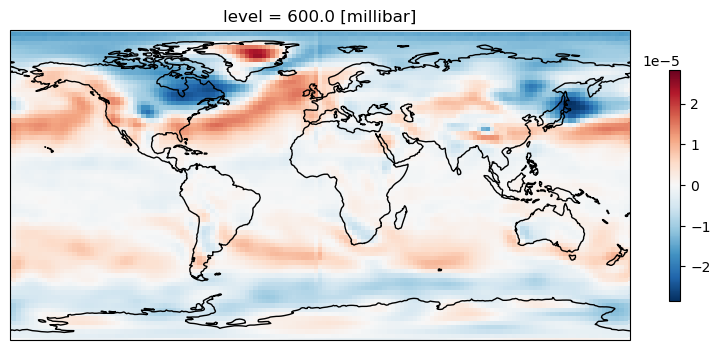

In [27]:
quickplot(EHFD.isel(level=12), cmap = 'RdBu_r')

<GeoAxes: title={'center': 'level = 300.0 [millibar]'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

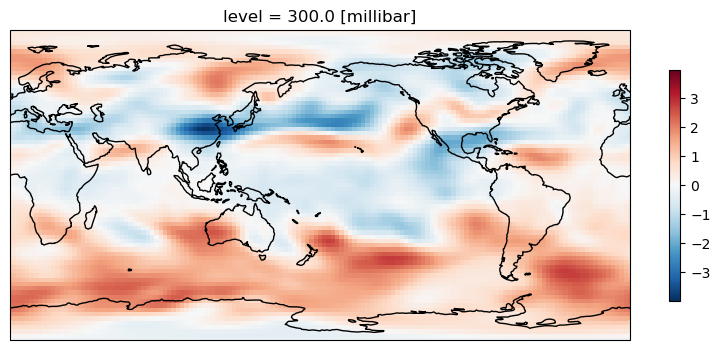

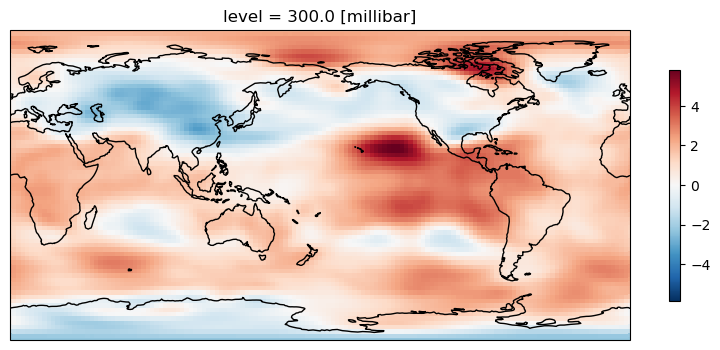

In [12]:
# subtropical cold anomalies over Asia during 1997/1998 el nino
ncep_jan_1997 = xr.open_dataset(target_dir + "/ncep_jan_1997.nc")
ncep_jan_1998 = xr.open_dataset(target_dir + "/ncep_jan_1998.nc")
quickplot((ncep_jan_1997.T - ncep_jan_all_mean.T).sel(level=300), cmap = 'RdBu_r',central_longitude=180)
quickplot((ncep_jan_1998.T - ncep_jan_all_mean.T).sel(level=300), cmap = 'RdBu_r',central_longitude=180)